In [0]:
import tensorflow
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.preprocessing import image
from tensorflow.keras.metrics import Precision,Recall
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
from google.colab.patches import cv2_imshow 
import cv2
import os
import numpy as np


In [25]:
from google.colab import drive
drive.mount('/content/gdrive/')


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
init_lr = 1e-3
epochs = 25
batch_size = 8

In [0]:
path = '/content/gdrive/My Drive/xray_dataset/train/'
imagePaths = list(paths.list_images(path))
print(imagePaths)
data = []
labels = []
for imagePath in imagePaths: 
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    image = cv2.resize(image, (224, 224)) 
    data.append(image)
    labels.append(label)


data = np.array(data) / 255.0
labels = np.array(labels)


In [0]:
lb =LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20,stratify=labels, random_state=42)

trainAug = ImageDataGenerator(
	rotation_range=15,
  width_shift_range = 0.2,
  height_shift_range = 0.2,
  zoom_range = 0.2,
  horizontal_flip = True,
	fill_mode="nearest")

In [0]:
tl_model = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))


In [0]:
for layer in tl_model.layers:
  layer.trainable = False

last_output = tl_model.output


In [0]:
x = layers.AveragePooling2D(pool_size=(4,4))(last_output)
x = layers.Flatten(name="flatten")(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.4)(x) 
x = layers.Dense(2, activation='softmax')(x)      

 
model = Model(inputs=tl_model.input, outputs=x)

opt = Adam(lr=init_lr, decay=init_lr / epochs)
model.compile(optimizer = opt, 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

#model.summary()

In [36]:
history = model.fit_generator(
	trainAug.flow(trainX, trainY, batch_size= batch_size),
	steps_per_epoch=len(trainX) // batch_size,
	validation_data=(testX, testY),
	validation_steps=len(testX) // batch_size,
	epochs=epochs)

Epoch 1/25
80/80 [==============================] - 11s 136ms/step - loss: 0.5292 - accuracy: 0.7283 - val_loss: 0.2275 - val_accuracy: 0.9627
Epoch 2/25
80/80 [==============================] - 10s 120ms/step - loss: 0.3077 - accuracy: 0.8815 - val_loss: 0.1350 - val_accuracy: 0.9689
Epoch 3/25
80/80 [==============================] - 10s 120ms/step - loss: 0.2382 - accuracy: 0.9131 - val_loss: 0.1083 - val_accuracy: 0.9814
Epoch 4/25
80/80 [==============================] - 10s 119ms/step - loss: 0.2148 - accuracy: 0.9115 - val_loss: 0.0811 - val_accuracy: 0.9752
Epoch 5/25
80/80 [==============================] - 9s 118ms/step - loss: 0.1897 - accuracy: 0.9289 - val_loss: 0.0671 - val_accuracy: 0.9752
Epoch 6/25
80/80 [==============================] - 10s 120ms/step - loss: 0.1625 - accuracy: 0.9447 - val_loss: 0.0570 - val_accuracy: 0.9752
Epoch 7/25
80/80 [==============================] - 10s 121ms/step - loss: 0.1345 - accuracy: 0.9573 - val_loss: 0.0548 - val_accuracy: 0.9752


In [38]:
predIdxs = model.predict(testX, batch_size=batch_size)

predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

              precision    recall  f1-score   support

     COVID19       0.99      0.99      0.99        80
      NORMAL       0.99      0.99      0.99        81

    accuracy                           0.99       161
   macro avg       0.99      0.99      0.99       161
weighted avg       0.99      0.99      0.99       161



In [39]:
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[79  1]
 [ 1 80]]
acc: 0.9876
sensitivity: 0.9875
specificity: 0.9877


In [0]:
model.save('/content/gdrive/My Drive/xray_dataset/final_model.h5')

<Figure size 432x288 with 0 Axes>

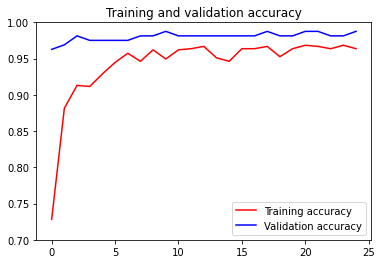

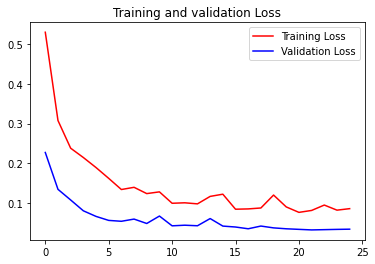

<Figure size 432x288 with 0 Axes>

In [41]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylim(0.7,1.0)
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation Loss')
plt.legend()
plt.figure()




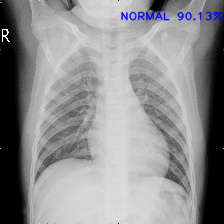

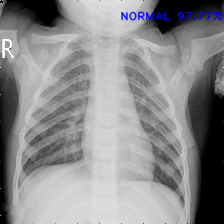

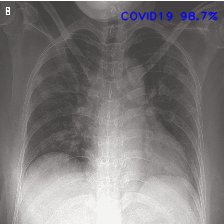

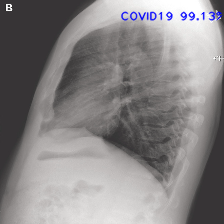

In [104]:

label_text = ['COVID19','NORMAL']
#model_new= tensorflow.keras.models.load_model('/content/gdrive/My Drive/xray_dataset/final_model.h5')
path = '/content/gdrive/My Drive/xray_dataset/validation/'
for count, filename in enumerate(os.listdir(path)): 
  image_raw = cv2.imread(path + filename)
  image = cv2.cvtColor(image_raw, cv2.COLOR_BGR2RGB) 
  image_reshape = cv2.resize(image, (224, 224)) 
  image = np.array(image_reshape) / 255.
  image = np.expand_dims(image, axis=0)
  classes_prob = model.predict(image)
  classes=np.argmax(classes_prob,axis=1)
  class_name = label_text[classes[0]]
  prob = np.around((classes_prob[0][classes[0]]) *100 , decimals = 2)
  text = class_name + " " + '{}'.format(prob) + '%'
  font = cv2.FONT_HERSHEY_PLAIN
  cv2.putText(image_reshape,text, (120,20), font, 0.8, (255, 0, 0), 1, cv2.LINE_AA)
  cv2_imshow(image_reshape)
 
 


